In [26]:
import pandas as pd 
import numpy  as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, mutual_info_score
from sklearn.model_selection import GridSearchCV, train_test_split

%matplotlib inline


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")

df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
features = df.columns[(df.columns != "converted")].tolist()
target = 'converted'
categorical = df.dtypes[df.dtypes == "object"].index.tolist()
numerical = df.dtypes[(df.dtypes != "object") & (df.columns != "converted")].index.tolist()

print("=================================================================================")
print("Numerical Features:")
print(numerical)
print("")
print("Categorical Features:")
print(categorical)
print("=================================================================================")



Numerical Features:
['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

Categorical Features:
['lead_source', 'industry', 'employment_status', 'location']


In [ ]:
# Gathered functions
def preprocess_dataframe(df, categorical, numerical):

    # Fill features
    for features in numerical:
        df[features] = df[features].fillna(0)

    for features in categorical:
        df[features] = df[features].fillna("NA")

    return df

def compute_correlation_matrix(df, numerical):
    corr = df[numerical].corr()

    sns.heatmap(corr, annot=True, fmt=".2f")

    # Print the max correlation values
    print("Maximum correlation values:")
    for col in corr.columns:
        max_corr = corr[col][corr[col] != 1.0].max()
        print(f"{col}: {max_corr:.2f}") 

def split_dataset(df, test_ratio=0.2, val_ratio=0.2, random_state=42, verbose=False):
    df_full_train, df_test = train_test_split(df, test_size=test_ratio,  random_state=random_state)
    df_train, df_val   = train_test_split(df_full_train, test_size= (val_ratio / (1 - test_ratio)), random_state=random_state)

    if verbose:
        print(f"Full train shape: {df_full_train.shape}")
        print(f"Train shape: {df_train.shape}")
        print(f"Validation shape: {df_val.shape}")
        print(f"Test shape: {df_test.shape}")
        
        if (len(df_full_train) != (len(df_train) + len(df_val))):
            print("Warning: Full train size is not equal to Train + Validation sizes")
        if (len(df) != (len(df_full_train) + len(df_test))):
            print("Warning: Full dataset size is not equal to Full train + Test sizes")

    return df_train, df_val, df_test
  
def prepare_dataset(df, categorical, encoder, type="training"):
    df = df.copy()
    
    if type == "training":
        ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        encoded_df = ohe.fit_transform(df[categorical])
        encoded_df = pd.DataFrame(encoded_df, columns=ohe.get_feature_names_out(categorical), index=df.index)

        return df.drop(columns=categorical).join(encoded_df), ohe
    
    elif type in ["validation", "test"]:
        encoded_df = encoder.transform(df[categorical])
        encoded_df = pd.DataFrame(encoded_df, columns=encoder.get_feature_names_out(categorical), index=df.index)

        return df.drop(columns=categorical).join(encoded_df)
    else:
        print("Error: type must be 'training', 'validation' or 'test'")
        return None
    
def create_data_matrices(df, features, target):
    return df[features], df[target]

def mutual_info_cat_score(series, y, verbose):
    mutual_score =  np.round(mutual_info_score(series, y), 2)

    if verbose:
        print(f"Mutual Information score between {series.name} and target: {mutual_score}")
    return mutual_score
    
def train_logistic_regression(X_train, y, C=1.0, random_state=42, max_iter=1000, solver="liblinear", model_type="normal", params_grid=None, verbose=False):
   
    if model_type == "grid_search":
        if params_grid is None:
            print("Error: params_grid must be provided for grid search")
            return None
        
        model = LogisticRegression(random_state=random_state, max_iter=max_iter, solver=solver)
        grid_search = GridSearchCV(model, params_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y)

        if verbose:
            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
            print(f"Training accuracy with best parameters: {grid_search.best_estimator_.score(X_train, y):.3f}")

        return grid_search.best_estimator_, grid_search 
    
    elif model_type == "normal":  
        model = LogisticRegression(C=C, random_state=random_state, max_iter=max_iter, solver=solver)
        model.fit(X_train, y)

        if verbose:
            print(f"Training accuracy: {model.score(X_train, y):.3f}")
        
        return model

def evaluate_model(model, X, y, verbose=False):
    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    if verbose:
        print(f"Accuracy: {accuracy:.3f}")

    return accuracy

def drop_columns(df, columns, verbose=False):
    df = df.copy()

    if isinstance(columns, str):
        df = df.iloc[:, ~df.columns.str.contains(columns)]
    elif isinstance(columns, list):
        for col in columns:
            df = df.iloc[:, ~df.columns.str.contains(col)]
    else:
        print("Error: columns must be a string or a list of strings")

    if verbose:
        print(f"Dropped columns: {columns}")
        print(f"New shape: {df.shape}")
        print(f"Remaining columns: {df.columns.tolist()}")
    
    return df



In [5]:
df = preprocess_dataframe(df, categorical, numerical)

In [6]:
## Question 1 What is the most frequent value (mode) of the column 'industry'?
print(df["industry"].value_counts())
df["industry"].mode()[0]

industry
retail           203
finance          200
other            198
healthcare       187
education        187
technology       179
manufacturing    174
NA               134
Name: count, dtype: int64


'retail'

Maximum correlation values:
number_of_courses_viewed: 0.01
annual_income: 0.03
interaction_count: 0.03
lead_score: 0.02


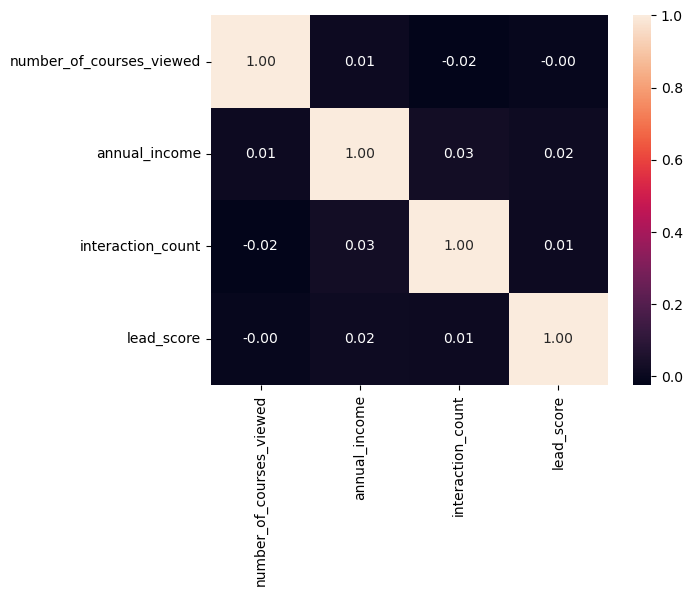

In [7]:
## Question 2: Compute a correlation matrix for the numerical features of your dataset.
compute_correlation_matrix(df, numerical)

In [8]:
# Prepare the dataset

df_train, df_val, df_test = split_dataset(df) 

In [9]:
## Question 3: Calculate the mutual information score between  y and the categorical features of your dataset.

mi = df_train[categorical].apply(mutual_info_cat_score, y=df_train[target], verbose=True)
mi = mi.sort_values(ascending=False)


Mutual Information score between lead_source and target: 0.04
Mutual Information score between industry and target: 0.01
Mutual Information score between employment_status and target: 0.01
Mutual Information score between location and target: 0.0


In [10]:
# Question 4: Train a logistic regression model with the categorical features of your dataset.

df_train_en, ohe = prepare_dataset(df_train, categorical, encoder=None, type="training")

In [11]:
df_val_en   = prepare_dataset(df_val,   categorical, encoder=ohe, type="validation")
df_test_en  = prepare_dataset(df_test,  categorical, encoder=ohe, type="test")

In [12]:
# create data matrices
X_train, y_train = create_data_matrices(df_train_en, df_train_en.columns[df_train_en.columns != target].tolist(), target)
X_val,   y_val   = create_data_matrices(df_val_en,   df_val_en.columns[df_val_en.columns != target].tolist(), target)
X_test,  y_test  = create_data_matrices(df_test_en,  df_test_en.columns[df_test_en.columns != target].tolist(), target)


In [13]:
df_train.shape, df_train_en.shape

((876, 9), (876, 32))

In [14]:
# Train the model
model = train_logistic_regression( X_train, y_train, verbose=True)

Training accuracy: 0.739


In [15]:
val_accuracy = evaluate_model(model, X_val, y_val, verbose=True)

Accuracy: 0.700


In [16]:
train_accuracy = evaluate_model(model, X_train, y_train, verbose=True)
train_accuracy

Accuracy: 0.739


0.7385844748858448

In [17]:
# Question 5: Find the useful feature with feature extraction
features = ["industry", "employment_status", "lead_score"]
    
    
def compare_accuracies(X, y, features_list, previous_accuracy):
    accuracies = {"base": previous_accuracy}

    for feature in features_list:
        print(f"Dropping Feature: {feature}")
        X_dropped = drop_columns(X, feature, verbose=False)        
        model = train_logistic_regression( X_dropped, y, verbose=False)
        accuracy_score = evaluate_model(model, X_dropped, y, verbose=False)
        accuracies[f"without_{feature}"] = accuracy_score

    accuracies_df = pd.DataFrame.from_dict(accuracies, orient='index', columns=['accuracy'])
    accuracies_df['difference'] = accuracies_df['accuracy'] - previous_accuracy
    return accuracies_df

accuracies_df = compare_accuracies(X_train, y_train, features, train_accuracy)
accuracies_df  

Dropping Feature: industry
Dropping Feature: employment_status
Dropping Feature: lead_score


,accuracy,difference
base,0.738584,0.000000
without_industry,0.740868,0.002283
without_employment_status,0.735160,-0.003425
without_lead_score,0.742009,0.003425


In [33]:
# Question 6: Training a regularized logistic regression
param_grid = { "C": [0.01, 0.1, 1, 10, 100] }

x_full_train, y_full_train = pd.concat([X_train, X_val]), pd.concat([y_train, y_val])

model, grid = train_logistic_regression(x_full_train, y_full_train, model_type="grid_search", params_grid=param_grid, verbose=True)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'C': 0.1}
Best cross-validation score: 0.737
All cross-validation results: {'mean_fit_time': array([0.00971308, 0.00901089, 0.00723653, 0.00778055, 0.00658908]), 'std_fit_time': array([0.00340373, 0.0015547 , 0.00030928, 0.00123663, 0.00061793]), 'mean_score_time': array([0.00437002, 0.00394793, 0.00328817, 0.00310912, 0.00263109]), 'std_score_time': array([0.00147438, 0.00061249, 0.00034673, 0.00043271, 0.00041351]), 'param_C': masked_array(data=[0.01, 0.1, 1.0, 10.0, 100.0],
             mask=[False, False, False, False, False],
       fill_value=1e+20), 'params': [{'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}], 'split0_test_score': array([0.74358974, 0.73931624, 0.73931624, 0.73931624, 0.73931624]), 'split1_test_score': array([0.75213675, 0.75641026, 0.75641026, 0.75641026, 0.75641026]), 'split2_test_score': array([0.73931624, 0.73504274, 0.73504274, 0.73504274, 0.73504274]), 'split3_test_score'

In [36]:
help(grid)

Help on GridSearchCV in module sklearn.model_selection._search object:

class GridSearchCV(BaseSearchCV)
 |  GridSearchCV(
 |      estimator,
 |      param_grid,
 |      *,
 |      scoring=None,
 |      n_jobs=None,
 |      refit=True,
 |      cv=None,
 |      verbose=0,
 |      pre_dispatch='2*n_jobs',
 |      error_score=nan,
 |      return_train_score=False
 |  )
 |
 |  Exhaustive search over specified parameter values for an estimator.
 |
 |  Important members are fit, predict.
 |
 |  GridSearchCV implements a "fit" and a "score" method.
 |  It also implements "score_samples", "predict", "predict_proba",
 |  "decision_function", "transform" and "inverse_transform" if they are
 |  implemented in the estimator used.
 |
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated grid-search over a parameter grid.
 |
 |  Read more in the :ref:`User Guide <grid_search>`.
 |
 |  Parameters
 |  ----------
 |  estimator : estimator object
 |      Th

Text(0, 0.5, 'Mean Cross-Validation Accuracy')

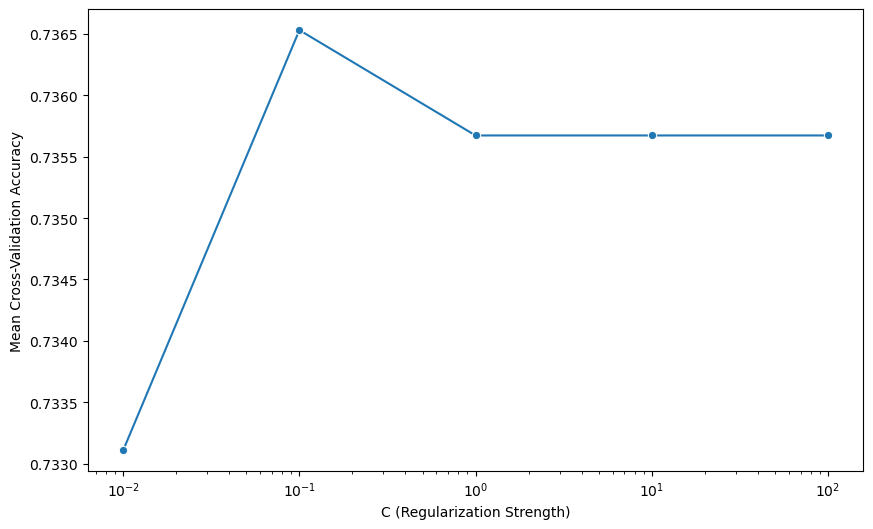

In [34]:
# Plot grid search accuracy results
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=grid.cv_results_['param_C'].data, y=grid.cv_results_['mean_test_score'], ax=ax, marker='o')
ax.set_xscale('log')
ax.set_xlabel('C (Regularization Strength)')
ax.set_ylabel('Mean Cross-Validation Accuracy')